# Black Box Model

### This model is experimental

In [635]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import QuantileTransformer

import sklearn
sklearn.set_config(display='text')

pd.set_option('display.max_columns', None)

In [636]:
train = pd.read_csv('./datasets/train.csv', index_col='Id')
test = pd.read_csv('./datasets/test.csv', index_col='Id')

Columns to map:
- MS SubClass (int to string)
- Lot Shape
- Utilities
- Land Slope
- Neighborhood
- Exter Qual
- Exter Cond
- Bsmt Cond
- Bsmt Exposure
- BsmtFin Type 1
- BsmtFin Type 2
- Heating QC
- Central Air
- Electrical
- Kitchen Qual
- Functional
- FireplaceQU
- Garage Finish
- Garage Qual
- Garage Cond
- Paved Drive
- Pool QC
- Fence 


In [637]:
train.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [638]:
print(train.shape, test.shape)

(2051, 80) (878, 79)


In [639]:
train['MS SubClass'].replace({
    20: 'a',
    30: 'b',
    40: 'c',
    45: 'd',
    50: 'e',
    60: 'f',
    70: 'g',
    75: 'h',
    80: 'i',
    85: 'j',
    90: 'k',
    120: 'l',
    150: 'm',
    160: 'n',
    180: 'o',
    190: 'p'
}, inplace=True)

test['MS SubClass'].replace({
    20: 'a',
    30: 'b',
    40: 'c',
    45: 'd',
    50: 'e',
    60: 'f',
    70: 'g',
    75: 'h',
    80: 'i',
    85: 'j',
    90: 'k',
    120: 'l',
    150: 'm',
    160: 'n',
    180: 'o',
    190: 'p'
}, inplace=True)

In [640]:
train['Lot Shape'] = np.where(train['Lot Shape'] == 'Reg', 1, 0)
test['Lot Shape'] = np.where(test['Lot Shape'] == 'Reg', 1, 0)

In [641]:
train['Utilities'] = np.where(train['Utilities'] == 'AllPub', 1, 0)
test['Utilities'] = np.where(test['Utilities'] == 'AllPub', 1, 0)

In [642]:
def binary_col(col, target):
    train[col] = np.where(train[col] == target, 1, 0)
    test[col] = np.where(test[col] == target, 1, 0)

In [643]:
train['Land Slope'].replace({
    'Sev': 1,
    'Mod': 2,
    'Gtl': 3
}, inplace=True)

test['Land Slope'].replace({
    'Sev': 1,
    'Mod': 2,
    'Gtl': 3
}, inplace=True)

In [644]:
# train['Neighborhood'].replace({
#                 'MeadowV': 1,
#                 'IDOTRR': 1,
#                 'BrDale': 1,
#                 'OldTown': 1,
#                 'Edwards': 1,
#                 'BrkSide': 1,
#                 'Sawyer': 2,
#                 'SWISU': 2,
#                 'Landmrk': 2,
#                 'Blueste': 2,
#                 'NAmes': 2,
#                 'NPkVill': 2,
#                 'Mitchel': 2,
#                 'Gilbert': 3,
#                 'SawyerW': 3,
#                 'NWAmes': 3,
#                 'Greens': 3,
#                 'Blmngtn': 3,
#                 'Crawfor': 3,
#                 'CollgCr': 3,
#                 'ClearCr':  3,
#                 'Timber': 4,
#                 'Somerst': 4,
#                 'Veenker': 4,
#                 'GrnHill': 4,
#                 'NoRidge': 4,
#                 'StoneBr': 4,
#                 'NridgHt': 4},
#         inplace = True)

# test['Neighborhood'].replace({
#                 'MeadowV': 1,
#                 'IDOTRR': 1,
#                 'BrDale': 1,
#                 'OldTown': 1,
#                 'Edwards': 1,
#                 'BrkSide': 1,
#                 'Sawyer': 2,
#                 'SWISU': 2,
#                 'Landmrk': 2,
#                 'Blueste': 2,
#                 'NAmes': 2,
#                 'NPkVill': 2,
#                 'Mitchel': 2,
#                 'Gilbert': 3,
#                 'SawyerW': 3,
#                 'NWAmes': 3,
#                 'Greens': 3,
#                 'Blmngtn': 3,
#                 'Crawfor': 3,
#                 'CollgCr': 3,
#                 'ClearCr':  3,
#                 'Timber': 4,
#                 'Somerst': 4,
#                 'Veenker': 4,
#                 'GrnHill': 4,
#                 'NoRidge': 4,
#                 'StoneBr': 4,
#                 'NridgHt': 4},
#         inplace = True)

In [645]:
def ordinal_map(col):
    train[col].replace({
                            'Po': 1,
                            'Fa': 2,
                            'TA': 3,
                            'Gd': 4,
                            'Ex': 5},
                            inplace=True
    )

    test[col].replace({
                        'Po': 1,
                        'Fa': 2,
                        'TA': 3,
                        'Gd': 4,
                        'Ex': 5},
                        inplace=True
    )

In [646]:
ordinal_map('Exter Qual')

In [647]:
ordinal_map('Exter Cond')

In [648]:
ordinal_map('Bsmt Qual')

In [649]:
ordinal_map('Bsmt Cond')

In [650]:
train['Bsmt Exposure'].replace({
    'No': 1,
    'Mn': 2,
    'Av': 3,
    'Gd': 4
}, inplace=True)

test['Bsmt Exposure'].replace({
    'No': 1,
    'Mn': 2,
    'Av': 3,
    'Gd': 4
}, inplace=True)

In [651]:
def ordinal_map2(col):
    train[col].replace({
        'Unf': 1,
        'LwQ': 2,
        'Rec': 3,
        'BLQ': 4,
        'ALQ': 5,
        'GLQ': 6
    }, inplace= True)
    test[col].replace({
        'Unf': 1,
        'LwQ': 2,
        'Rec': 3,
        'BLQ': 4,
        'ALQ': 5,
        'GLQ': 6
    }, inplace= True)

In [652]:
ordinal_map2('BsmtFin Type 1')

In [653]:
ordinal_map2('BsmtFin Type 2')

In [654]:
ordinal_map('Heating QC')

In [655]:
binary_col('Central Air', 'Y')

In [656]:
ordinal_map('Kitchen Qual')

In [657]:
train['Functional'].replace({
    'Sal': 1,
    'Sev': 2,
    'Maj2': 3,
    'Maj1': 4,
    'Mod': 5,
    'Min2': 6,
    'Min1': 7,
    'Typ': 8
}, inplace=True)

test['Functional'].replace({
    'Sal': 1,
    'Sev': 2,
    'Maj2': 3,
    'Maj1': 4,
    'Mod': 5,
    'Min2': 6,
    'Min1': 7,
    'Typ': 8
}, inplace=True)

In [658]:
ordinal_map('Fireplace Qu')

In [659]:
train['Garage Finish'].replace({
    'Unf': 1,
    'RFn': 2,
    'Fin': 3
}, inplace=True)

test['Garage Finish'].replace({
    'Unf': 1,
    'RFn': 2,
    'Fin': 3
}, inplace=True)

In [660]:
ordinal_map('Garage Qual')

In [661]:
ordinal_map('Garage Cond')

In [662]:
train['Paved Drive'].replace({
    'N': 1,
    'P': 2,
    'Y': 3
}, inplace = True)

test['Paved Drive'].replace({
    'N': 1,
    'P': 2,
    'Y': 3
}, inplace = True)

In [663]:
ordinal_map('Pool QC')

In [664]:
train['Fence'].replace({
    'MnWw': 1,
    'GdWo': 2,
    'MnPrv': 3,
    'GdPrv':4
}, inplace=True)

test['Fence'].replace({
    'MnWw': 1,
    'GdWo': 2,
    'MnPrv': 3,
    'GdPrv':4
}, inplace=True)

In [665]:
train['Fence'].value_counts()

3.0    227
4.0     83
2.0     80
1.0     10
Name: Fence, dtype: int64

In [666]:
test['Fence'].value_counts()

3.0    103
4.0     35
2.0     32
1.0      2
Name: Fence, dtype: int64

In [667]:
train['all_flr_sf'] = train['1st Flr SF'] + train['2nd Flr SF']
test['all_flr_sf'] = test['1st Flr SF'] + test['2nd Flr SF']

In [668]:
def create_poly(name, f1, f2):
    train[name] = train[f1] * train[f2]
    test[name] = test[f1] * test[f2]

In [669]:
create_poly('overall_qual_and_cond', 'Overall Qual', 'Overall Cond')
create_poly('qual_gr_liv', 'Overall Qual', 'Gr Liv Area')

In [670]:
#create_poly('new_col', 'BsmtFin SF 1', 'Bsmt Full Bath')
#create_poly('new_col2', 'Neighborhood_mapped', 'all_flr_sf')
#create_poly('new_col3', 'Neighborhood_mapped', 'Gr Liv Area')


In [671]:
create_poly('new_col6', 'all_flr_sf', 'Overall Qual')
create_poly('new_col7', 'Overall Qual', 'Overall Qual')
create_poly('new_col8', 'Gr Liv Area', 'Gr Liv Area')
#create_poly('new_col9', 'Neighborhood_mapped', 'Neighborhood_mapped')
#create_poly('new_col10', 'Kitchen Qual', 'Neighborhood_mapped')
create_poly('new_col11', 'Lot Area', 'Overall Qual')

<AxesSubplot:>

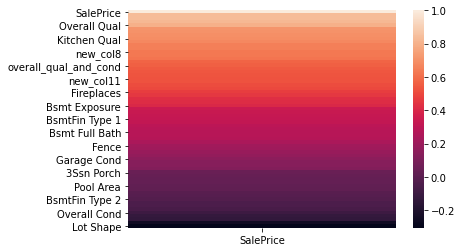

In [672]:
sns.heatmap(train.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False))

In [673]:
## Get rid of sale price outliers
#train = train[train['SalePrice'] < 600000]
train.drop(1554, axis='index', inplace=True)
train= train[train['Gr Liv Area']<4000]
train.drop(182, axis='index', inplace=True)
#train = train[train['1st Flr SF']<3500]
train.drop([1897], axis='index', inplace=True)
#train = train[train['all_flr_sf']<3200]
#train = train[train['Garage Cars'] != 5]
#train.drop([873,554], axis='index', inplace=True)
#train = train[train['Mas Vnr Area'] < 1400]
#train = train[train['Total Bsmt SF'] < 3000]
#train = train[train['TotRms AbvGrd'] < 13]
#train = train[train['Lot Area']<60000]
#train = train[train['Lot Frontage'] < 300]
#train[(train['neighborhood']==1) & (training['saleprice'] > 400000)]

In [674]:
#train.set_index('Id', inplace=True)
#test.set_index('Id', inplace=True)

In [675]:
X = train.drop(['SalePrice', 'PID'], axis=1)
y = np.log(train['SalePrice'])

test = test.drop(['PID'], axis=1)

In [676]:
X.shape

(2046, 85)

In [677]:
test.shape

(878, 85)

In [678]:
test.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,all_flr_sf,overall_qual_and_cond,qual_gr_liv,new_col6,new_col7,new_col8,new_col11
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2658,p,RM,69.0,9142,Pave,Grvl,1,Lvl,1,Inside,3,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,3,2,Stone,2.0,3.0,1.0,1.0,0,1.0,0,1020,1020,GasA,4,0,FuseP,908,1020,0,1928,0,0,2,0,4,2,2,9,8,0,NaN,Detchd,1910.0,1.0,1,440,1.0,1.0,3,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD,1928,48,11568,11568,36,3717184,54852
2718,k,RL,NaN,9662,Pave,NaN,0,Lvl,1,Inside,3,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,3,3,CBlock,4.0,3.0,1.0,1.0,0,1.0,0,1967,1967,GasA,3,1,SBrkr,1967,0,0,1967,0,0,2,0,6,2,3,10,8,0,NaN,Attchd,1977.0,3.0,2,580,3.0,3.0,3,170,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD,1967,20,9835,9835,25,3869089,48310
2414,f,RL,58.0,17104,Pave,NaN,0,Lvl,1,Inside,3,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,4,3,PConc,4.0,4.0,3.0,6.0,554,1.0,0,100,654,GasA,5,1,SBrkr,664,832,0,1496,1,0,2,1,3,1,4,7,8,1,4.0,Attchd,2006.0,2.0,2,426,3.0,3.0,3,100,24,0,0,0,0,NaN,NaN,NaN,0,9,2006,New,1496,35,10472,10472,49,2238016,119728
1989,b,RM,60.0,8520,Pave,NaN,1,Lvl,1,Inside,3,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,4,3,CBlock,3.0,3.0,1.0,1.0,0,1.0,0,968,968,GasA,3,1,SBrkr,968,0,0,968,0,0,1,0,2,1,3,5,8,0,NaN,Detchd,1935.0,1.0,2,480,2.0,3.0,1,0,0,184,0,0,0,NaN,NaN,NaN,0,7,2007,WD,968,30,4840,4840,25,937024,42600
625,a,RL,NaN,9500,Pave,NaN,0,Lvl,1,Inside,3,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,3,3,CBlock,4.0,3.0,1.0,4.0,609,1.0,0,785,1394,GasA,4,1,SBrkr,1394,0,0,1394,1,0,1,1,3,1,3,6,8,2,4.0,Attchd,1963.0,2.0,2,514,3.0,3.0,3,0,76,0,0,185,0,NaN,NaN,NaN,0,7,2009,WD,1394,30,8364,8364,36,1943236,57000


In [679]:
#qt2 = QuantileTransformer(output_distribution='normal')
#y = qt2.fit_transform(y)

In [680]:
imp_knn = KNNImputer(add_indicator=True)
scaler = StandardScaler()
power = PowerTransformer()
qt = QuantileTransformer(output_distribution='normal')
qt2 = QuantileTransformer(output_distribution='normal')

In [681]:
imp_const = SimpleImputer(strategy='constant', fill_value='None', add_indicator=True)
ohe = OneHotEncoder(handle_unknown='ignore')

In [682]:
num_cols = make_column_selector(dtype_include='number')
cat_cols = make_column_selector(dtype_exclude='number')

In [683]:
preprocessor = make_column_transformer(
    (make_pipeline(imp_knn, qt), num_cols),
    (make_pipeline(imp_const, ohe), cat_cols)
)

In [684]:
pipe = make_pipeline(preprocessor, SelectKBest(f_regression), Ridge())

In [685]:
params = {
    'selectkbest__k': range(255, 270),
    'ridge__fit_intercept': [True, False],
    'ridge__alpha': range(2, 10)
}

In [686]:
gs = GridSearchCV(pipe, params, cv=15, n_jobs=-1)

In [687]:
gs.fit(X, y)

/Users/alexander.fioto/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=15,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer(add_indicator=True)),
                                                                                         ('quantiletransformer',
                                                                                          QuantileTransformer(output_distribution='normal'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f90419d94d0>),
                                                                        ('pipeline-2',
                                                                         Pipe...
                     

In [688]:
gs.score(X, y)

0.9432567749159488

Training Score 0.9432567749159488
RMSE Training 0.09620500520523756
{'ridge__alpha': 7, 'ridge__fit_intercept': True, 'selectkbest__k': 266}


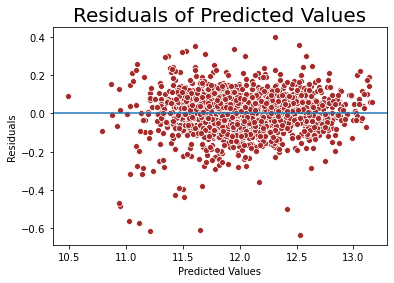

In [693]:
preds = gs.predict(X)
resids = np.array(y) - preds

print('Training Score', gs.score(X, y))
print('RMSE Training', mean_squared_error(y, preds, squared=False))
print(gs.best_params_)


sns.scatterplot(x=preds, y=resids, color='brown')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline();
plt.title('Residuals of Predicted Values', fontsize=20)
plt.savefig('./assets/BLACKBOX Residuals')

In [694]:
# Creating predictions CSV
test_preds = gs.predict(test)
log_preds = np.exp(test_preds)
test1 = pd.read_csv('./datasets/test.csv')
submission= pd.DataFrame(log_preds, index=test1['Id'])
submission.columns = ['saleprice']

In [695]:
submission.to_csv('./datasets/submission.csv')